# custom instance segmentation by yolonas、sam、text.

In [1]:
#base config
#you can use these label to find targets in image.
label_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
class_to_idx = {label_list[i]:i for i in range(len(label_list))}
#you want to find target's label for image's text.
label_path = 'temp/images/textimg.png'
image_path = 'temp/images/person.jpg'
infer_device = "cuda"


In [3]:
#import all the module of python
from matplotlib import pyplot as plt
import numpy as np

import cv2
from paddleocr import PaddleOCR, draw_ocr
from super_gradients.training import models as yolon
from segment_anything import sam_model_registry, SamPredictor
import torch


libpng warning: iCCP: known incorrect sRGB profile


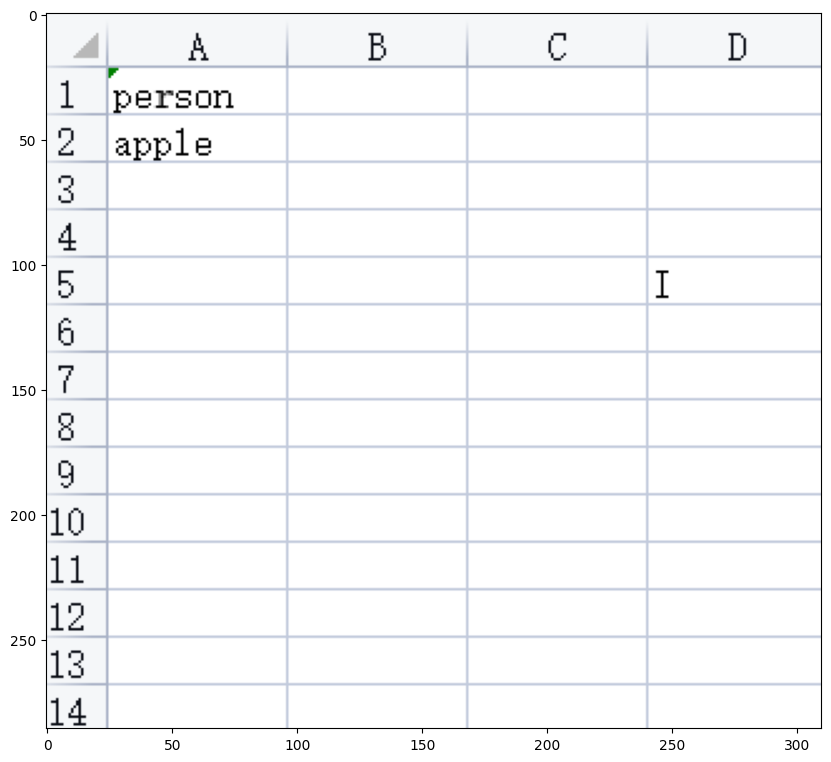

In [4]:
#ready the image's text to RAM

text_image = cv2.imread(label_path)
text_image = cv2.cvtColor(text_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(text_image)
plt.axis('on')
plt.show()

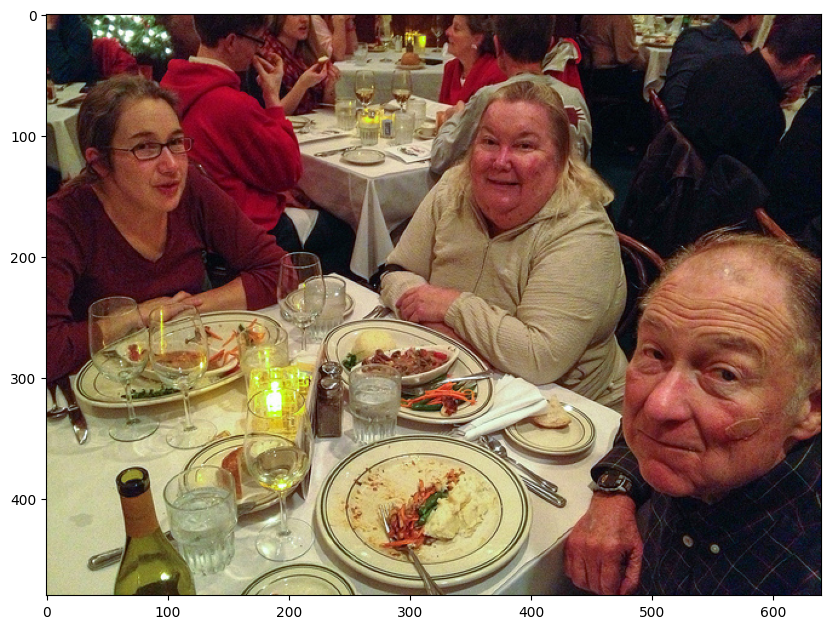

In [5]:
#ready the image to RAM

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [6]:
#define some ultity tools.
def show_max_mask(masks, ax, random_color=False):
    max_mask_index=None
    max_area=0
    for index,mask in enumerate(masks):
        area=np.sum(mask)
        if area>max_area:
            max_area=area
            max_mask_index=index
    if max_mask_index:
        mask=masks[max_mask_index]
    
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
    
def show_box_and_label(boxes,ax,labels):  
    for index,box in enumerate(boxes):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
        ax.text(x0, y0, labels[index], fontsize=11)
    
    
    

## define config of SAM.

In [7]:
#set up the sam engine
sam_checkpoint = "temp/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=infer_device)
sam_engine = SamPredictor(sam)
sam_engine.set_image(image)


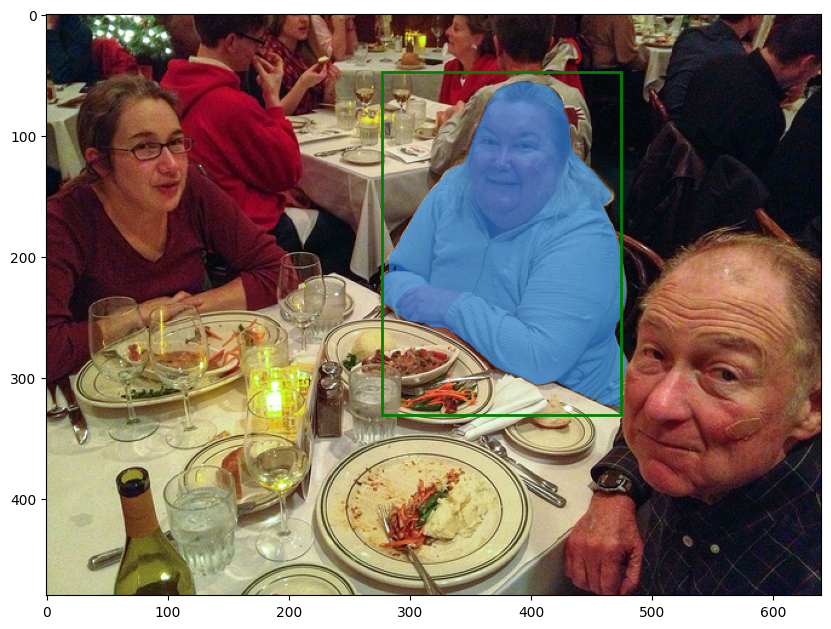

In [8]:
#test the sam engine is ok using simple infer.
input_box = np.array([277, 47, 474, 331])
masks, scores, logits = sam_engine.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_max_mask(masks,plt.gca())
show_box(input_box, plt.gca())

## define config of YOLO-NAS.

In [9]:
##set up the yolo-nas engine
yolon_engine = yolon.get('yolo_nas_l', pretrained_weights='coco') # yolo_nas_l is the yolo_nas large model

[2023-07-10 13:50:01] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


[2023-07-10 13:50:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


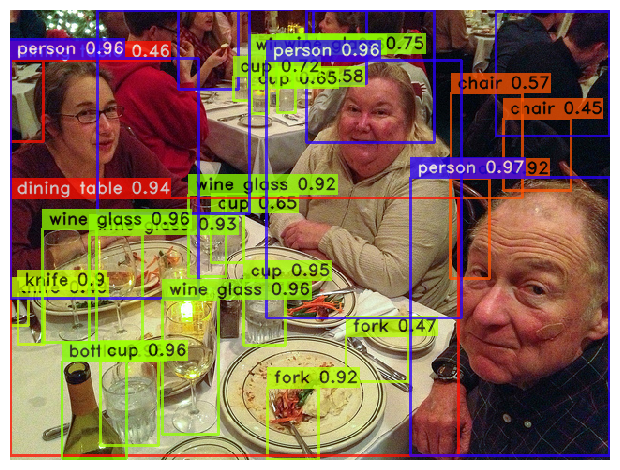

In [10]:
#test the yolo-nas engine is ok using simple infer.
detection_pred=yolon_engine.predict(image, conf=0.45)
detection_pred.show()

## define config of PPOCR.

In [11]:
ocr = PaddleOCR()  # need to run only once to download and load model into memory
result = ocr.ocr(label_path, cls=False)

boxes = [line[0] for line in result[0]]
txts = [line[1][0] for line in result[0]]
scores = [line[1][1] for line in result[0]]

[2023/07/10 13:50:05] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/seeking/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/seeking/.paddleocr/whl/det/ch/ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e

libpng warning: iCCP: known incorrect sRGB profile


[2023/07/10 13:50:11] ppocr DEBUG: dt_boxes num : 21, elapse : 4.373408317565918
[2023/07/10 13:50:11] ppocr DEBUG: rec_res num  : 21, elapse : 0.06459283828735352


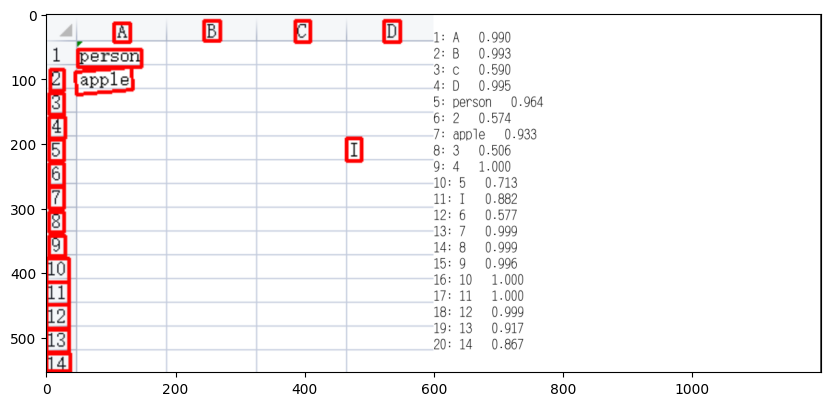

In [12]:
im_show = draw_ocr(text_image, boxes, txts, scores, font_path='./OCR/doc/fonts/chinese_cht.ttf')
plt.figure(figsize=(10,10))
plt.imshow(im_show)
plt.axis('on')
plt.show()


## construct the function of instance segmentation.

In [13]:
## get text for text's image
find_label = []
for txt in txts: #rec
    if txt in label_list:
        find_label.append(txt)
print(find_label)

['person', 'apple']


In [14]:
##postprocess result of predict
input_boxes_list=[]
input_boxes_label_list=[]
predict_labels = detection_pred[0].prediction.labels.tolist()
predict_bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
predict_labels = detection_pred[0].prediction.labels.tolist()

## get instance segmentation's target labels.
instance_seg_target_labels=[class_to_idx.get(label) for label in find_label]
print(instance_seg_target_labels)
for i,predict_label in enumerate(predict_labels):
    if int(predict_label)in instance_seg_target_labels:
        input_boxes_list.append(predict_bboxes_xyxy[i].copy())
        input_boxes_label_list.append(label_list[int(predict_label)])
print(len(input_boxes_list))

[0, 47]
8


In [15]:
#put the prompt boxes to sam.
input_boxes = torch.tensor(input_boxes_list, device=infer_device)
transformed_boxes = sam_engine.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = sam_engine.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


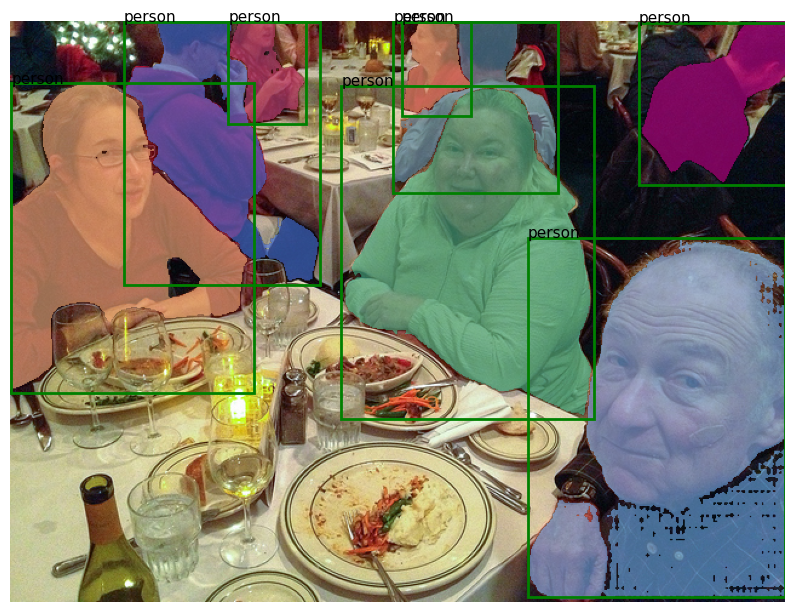

In [16]:
#draw the messages.
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
show_box_and_label(input_boxes_list,plt.gca(),input_boxes_label_list)
plt.axis('off')
plt.show()